# Topic Modeling of Job Descriptions

### Purpose:
Our users have looked at the list of recommended jobs and often said things like, "I want to find jobs that are similar to this one.". They want the ability to explore other jobs and find the right fit for their career. We are exploring multiple routes to solve this user need. We hypothesize that by using Topic Modeling (LDA) on the job descriptions, we will be able to categorize jobs into buckets that represent similar opportunities as each other. "Jobs like this one" will probably have similar words used to describe the role and the required activities. 

**Experiment to Consider:**
I wonder if the company name for the job might bias some of the topics that are identified. There are some companies that have many jobs posted. We might want to consider removing the company name from the corpus before we apply LDA. 

### Other solutions to consider:
- 2d Projection of the embeddings: This has merit because it allows the user to see all jobs in one big view and allows them to explore all the opportunites. However, it is non-intuitive for non-technical users. We've recieved mixed feedback on the use of an embeddings map to service this need.  
- Semantic Search: This approach is interesting because it is likely the lowest LOE, but the major drawback is that we might just return jobs from the same company and might not serve the true need of the user. 
- Clustering Algorithms: Various clustering algorithms would allow us to see the grouping of different jobs based on reduced features from the original high dimension space. We have experimented with this by taking the 768 dimension embedding and applying PCA to reduce down to 250 dimensions. The key challenge with this approach is that PCA data is non-linear and most clustering algortithms assume linear relationships in the data. Also, we wouldn't know WHY the clusters are created. 

----



## About LDA:

At a high level: 
The user has to manually choose the number of topics that should be discovered in the training corpus. This should be driven by a combination of domain knowledge and also experimentation. 

LDA will parse all the documents at then determine which words are typically shwon with high frequency for a given topic. 

We can then pass in a document and given the word distrubution, the model will tell us which topic this likely is associated with. 

- Assumptions of LDA for Topic Modeling:
    - Documents with similar topics use similar groups of words
    - Latent topics can then be found by search for groups of words that frequently occur together in the documents across the corpus. 

Mathmatically Speaking...
- Assumptions of LDA for Topic Modeling
    - Documents are probability distributions over latent topics
    - Topics themselves are probability distributions over words. 


We are NOT saying that Document 1 is an example Topic 1. Instead we are saying that there is a probability that Document 1 is an example of Topic 1 because it contains many words that are found in Topic 1. There is a greater probability that it is an example of Topic 1, but there is also a chance it could be another one of the given topics too, just a lower probability of this. 

LDA represents documents as mixtures of topics that spit out words with certain probabilities. 

-----

Now imagine that we have a set of documents

We've chosen some fixed number of K Topics to discover and want to use LDA to learn the topic representation of each document and the words associated with each document. 

Go through each document, and randomly assign each word in the document to one of the K Topics

This random assignment already gives you both topic representations of all the documents and word distrubtions of all the topics. (But please be aware... These initial random topics won't make any sense)

Now we iterate over each word in every document to improve these topics. 

For each word in each document and for each topic t we calcuate:
    p(word w | topic t) = "The porportion of assignments to topic t over all documents that come from this word w"

After repeating the previous step a large number of times, we eventually reach a roughly steady state where the assignments are acceptable. 

We end up with an output such as:
    - Document assigned to Topic #4
    - Most common words (highest probability) for Topic #4:
        [cat, vet, bird, dogs]
    - It is up to the user to intepret these topics



----

### Determining the right number of topics

Several of the videos that I watched, all suggested that the user must specify the number of topics, GPT 4 tells me that GenSim has some built in functions that can help determine the best number of topics. 

1. Perplexity Score
Perplexity is a measure of how well a probabilistic model predicts a sample. In the context of LDA, lower perplexity indicates a better fit to the data. You can calculate the perplexity for different numbers of topics and choose the one with the lowest perplexity.

2. Coherence Score
Coherence measures the semantic similarity between high-scoring words in the topics. A higher coherence score usually indicates more interpretable topics. The coherence score can be calculated using various metrics such as C_v, C_umass, C_uci, and C_npmi.

3. Topic Coherence via Grid Search
You can perform a grid search over a range of topic numbers and calculate coherence scores for each, then choose the number of topics that maximizes the coherence score.

4. Elbow Method (Coherence Score)
Similar to the elbow method in K-Means clustering, you can plot the coherence score against the number of topics and look for the point where the improvement starts to diminish.

5. Human Judgment and Interpretability
Ultimately, human judgment on the interpretability and coherence of topics can be crucial. Sometimes, the optimal number of topics is the one that makes the most sense from a business or research perspective.


### References 
https://www.youtube.com/watch?v=be7Xd2Ntai8


In [1]:


import os
import inspect
import json
import sys
import time
import logging
import uuid 
import pandas as pd
from dotenv import load_dotenv
from datetime import datetime
from pathlib import Path

from operation_battleship_common_utilities.JobPostingDao import JobPostingDao
from operation_battleship_common_utilities.CandidateRequirementsDao import CandidateRequirementsDao
from operation_battleship_common_utilities.JobResponsibilitiesDao import JobResponsibilitiesDao
from operation_battleship_common_utilities.JobSkillsDao import JobSkillsDao
from operation_battleship_common_utilities.JobKeyWordsDao import JobKeyWordsDao
from operation_battleship_common_utilities.JobTitleCategoryClassifier import JobTitleCategoryClassifier
from operation_battleship_common_utilities.FailureLogger import FailureLogger

from operation_battleship_common_utilities.NomicAICaller import NomicAICaller
from operation_battleship_common_utilities.OpenAICaller import OpenAICaller
from operation_battleship_common_utilities.PineConeDatabaseCaller import PineConeDatabaseCaller

load_dotenv()

c:\Users\caraw\AppData\Local\Programs\Python\Python311\Lib\site-packages\pinecone\data\index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


True

In [2]:
# Get the list of jobs from the database and print the columns in the DF.
jobPostingDao = JobPostingDao()
allJobsDf = jobPostingDao.getAllJobs()
columns = allJobsDf.columns
print(columns)

2024-05-16 18:07:46,881 - INFO - JobPostingDao class initialized


Index(['job_posting_id', 'company_id', 'posting_url', 'posting_source',
       'posting_source_id', 'job_title', 'full_posting_description',
       'job_description', 'is_ai', 'job_salary',
       'job_posting_company_information', 'job_posting_date',
       'job_insertion_date', 'job_last_collected_date', 'job_active',
       'salary_low', 'salary_midpoint', 'salary_high', 'city', 'state',
       'is_genai', 'job_skills', 'is_ai_justification', 'work_location_type',
       'job_category', 'kmeansclusterid', 'dbscanclusterid', 'opticsclusterid',
       'kmeansclustertopicname', 'dbscanclustertopicname',
       'opticsclustertopicname'],
      dtype='object')


In [3]:
# We only need the column that contains the job description. 
# We will take a short peek at the top records to see a snippet of the values
jobDescriptionDf = allJobsDf[['full_posting_description']]
jobDescriptionDf.head()


,full_posting_description
0,EquipmentShare is Hiring a Principal Product M...
1,If you are a Remote Associate Product Manager ...
2,Overview\n\nJob Description\n\nCoStar Group (N...
3,ClubLabs is the digital acceleration team for ...
4,"Hi, we're Brigit! A holistic financial health ..."


In [5]:
# We can see the whole description for one of the rows 
# We can also see the number of rows in the dataframe
jobDescriptionDf['full_posting_description'][8]
#len(jobDescriptionDf)

'Are you a team player? Are you curious to learn? Are you interested in working in meaningful projects? Do you want to work with cutting-edge technology? Are you interested in being part of a team that is working to transform and do things differently? If so, LPL Financial is the place for you!\n\nLPL Financial (Nasdaq: LPLA) was founded on the principle that the firm should work for the advisor, and not the other way around. Today, LPL is a leader* in the markets we serve, supporting more than 18,000 financial advisors, 800 institution-based investment programs and 450 independent RIA firms nationwide. We are steadfast in our commitment to the advisor-centered model and the belief that Americans deserve access to personalized guidance from a financial advisor. At LPL, independence means that advisors have the freedom they deserve to choose the business model, services, and technology resources that allow them to run their perfect practice. And they have the freedom to manage their cli

In [6]:
# LDA for this notebook will be done using the SkLearn Library. 
# We will explore GenSim in another notebook
from sklearn.feature_extraction.text import CountVectorizer


In [7]:
# Max DF allows us to ignore certain terms that have really high document frequency. If Software or Product are found in 95% of the jobs, then that term would be excluded.  When max_df=0.9 that means we would discard words that appear in 90% of the documents. 
# Min DF allows us to set the minimum doc frequcny. If set to an integer value of 5, this would mean that a word would need to show up in at least 5 documents in order to be counted. 
# For both of these input parameters, you can pass in a ratio of less than 1 or even an integer that specifies a raw number of documents. 

cv = CountVectorizer(max_df=0.95, min_df=5, stop_words='english')

In [8]:
dtm = cv.fit_transform(jobDescriptionDf['full_posting_description'])

In [9]:
dtm

<69413x31542 sparse matrix of type '<class 'numpy.int64'>'
	with 21293198 stored elements in Compressed Sparse Row format>

In [10]:
# I don't know the correct number of topics, choosing a value for now and we will look for scientific approaches to this later. 
from sklearn.decomposition import LatentDirichletAllocation

totalTopics = 25
randomSeed = 42

lda = LatentDirichletAllocation(n_components=totalTopics, random_state=randomSeed)

In [11]:
lda.fit(dtm)

LatentDirichletAllocation(n_components=25, random_state=42)

In [23]:
# Explore the vocabulary of the words
# How many words are in the corpus? 
# What is the object type of the get feature names?

print( len(cv.get_feature_names_out()) )
print (type(cv.get_feature_names_out()) )
print (cv.get_feature_names_out()[5655])



31542
<class 'numpy.ndarray'>
cao


In [22]:
# Get the feature names
feature_names = cv.get_feature_names_out()

# Write the feature names to a file, each on a new line
with open('features.txt', 'w', encoding='utf-8') as f:
    for feature in feature_names:
        f.write(feature + '\n')

In [26]:
# Grab the topics
print (len(lda.components_))
print (type(lda.components_))
print(lda.components_.shape)


25
<class 'numpy.ndarray'>
(25, 31542)


In [28]:
# Each row of lda.components represents a topic. Remember, there are K Topics (We set K to 25)
# Arg sort will give us the ranked order for each index value of the high probability words. 
# array([10, 200, 1]) would show:
# arraye([2, 0 , 1]) Array index 2 has the lowest value, index 0 has the second lowest value and index 1 has the this lowest value. 
singleTopic = lda.components_[0]
singleTopic.argsort()

array([11529, 19517, 10065, ..., 17808,  5411, 22602], dtype=int64)

In [30]:
# We can get the ten highest probability words for this topic:
# Reminder: Arg Sort --> Index Positions sorted from Least -> Greatest
# Starting at index postiion -10, go all the way to the end.
singleTopic.argsort()[-10:]




array([ 2592, 29873, 28136, 31103,  9164, 28124, 24273, 17808,  5411,
       22602], dtype=int64)

In [32]:
# Create an array of the words and then print the words
topWordsForTopic = singleTopic.argsort()[-25:]

for index in topWordsForTopic:
    print(cv.get_feature_names_out()[index])

customer
manager
ensure
working
delivery
needs
technology
years
products
functional
solutions
technical
stakeholders
skills
ability
agile
user
teams
work
development
team
requirements
management
business
product


In [35]:
# Grab the highest probability words per topic

for i,topic in enumerate(lda.components_):
    print(f"The Top 15 words for topic #{i}]")
    print([cv.get_feature_names_out()[index] for index in topic.argsort()[-15:]])
    print("\n")
    print("\n")

The Top 15 words for topic #0]
['solutions', 'technical', 'stakeholders', 'skills', 'ability', 'agile', 'user', 'teams', 'work', 'development', 'team', 'requirements', 'management', 'business', 'product']




The Top 15 words for topic #1]
['skills', 'job', 'sales', 'com', 'team', 'roles', 'company', 'product', 'benefits', 'new', 'analytics', 'business', 'marketing', 'salesforce', 'data']




The Top 15 words for topic #2]
['new', 'cgs', 'work', 'data', 'large', 'team', 'capital', 'time', 'model', 'models', 'learning', 'training', 'applied', 'ai', 'research']




The Top 15 words for topic #3]
['inclusive', 'business', 'including', 'customer', 'management', 'customers', 'products', 'support', 'pearson', 'education', 'skills', 'learning', 'team', 'work', 'product']




The Top 15 words for topic #4]
['years', 'work', 'team', 'machine', 'technologies', 'solutions', 'ml', 'science', 'development', 'learning', 'technical', 'engineering', 'software', 'ai', 'data']




The Top 15 words for t

In [36]:
topicResults = lda.transform(dtm)

In [38]:
# An array where each row is the job description and each column is a probability that the topic is represented in this document. 
print(topicResults.shape)

# For document at index 50, round to two decimal places to see the probability of the topic being represented
print(topicResults[50].round(2))

(69413, 25)
[0.   0.01 0.   0.09 0.05 0.   0.   0.02 0.   0.   0.09 0.   0.36 0.
 0.07 0.   0.   0.   0.18 0.01 0.   0.   0.04 0.   0.08]


2024-05-17 11:32:19,610 - INFO - generated new fontManager


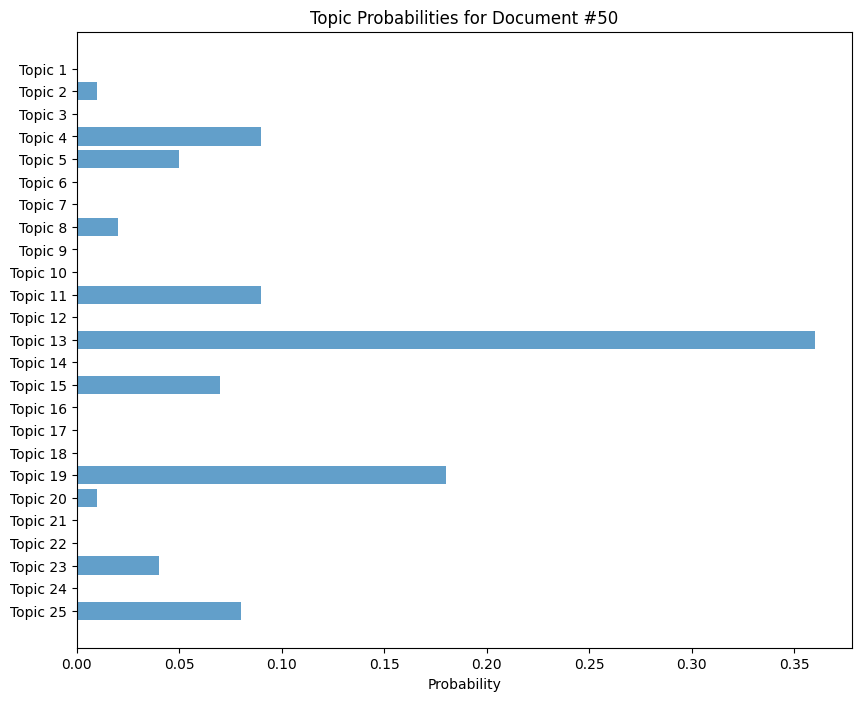

In [39]:
#Lets see this in a visual representation now
import matplotlib.pyplot as plt
import numpy as np

# For document at index 50, round to two decimal places
topic_probs = topicResults[50].round(2)

# Number of topics (assuming you have 25 topics)
num_topics = len(topic_probs)

# Create a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(np.arange(num_topics), topic_probs, align='center', alpha=0.7)
plt.yticks(np.arange(num_topics), [f'Topic {i+1}' for i in range(num_topics)])
plt.xlabel('Probability')
plt.title('Topic Probabilities for Document #50')
plt.gca().invert_yaxis()  # Invert y-axis to have topic 1 at the top
plt.show()

**Topic 13 Words**

The Top 15 words for topic #13]
['required', 'information', 'client', 'team', 'process', 'analysis', 'program', 'projects', 'requirements', 'skills', 'support', 'work', 'management', 'business', 'project']

In [40]:
# For the topic with this highest probability, we can look at the document and see what it says and get an intution for the topic itself. 
jobDescriptionDf['full_posting_description'][50]


"HOVER is a software platform offering measurement, visualization, estimation, and ordering solutions to the construction and insurance markets. HOVER uses patented technology making it possible for anyone with a smartphone camera to create an interactive 3D model, complete with detailed measurements and powerful design features. The data produced is extremely valuable as it generates a single source of truth for the physical world allowing for more veracity throughout the home improvement and insurance processes. We’ve found an incredibly strong product-market fit across construction, insurance, and newly emerging, with Homeowners. What's the secret sauce? Cutting edge technology, an exceptional culture, and a commitment to our values (Think. Do. Serve.).\n\nWith our team of investors, including Google Ventures, Menlo Ventures, The Home Depot, and leading Insurance carriers such as Travelers, State Farm, and Nationwide, HOVER is committed to continuing our success and facilitating gro

In [41]:
# Run Argmax to just get the index position of the highest probability
# Note the offset value. We list 12 here, but the chart above shows 13 due to indexes starting at zero.  
print(topicResults[50].argmax())

12


In [43]:
# We can create a new column in the original datframe and apply the topic to the job posting
jobDescriptionDf.loc[:, "Topic"] = topicResults.argmax(axis=1)

In [46]:
print(jobDescriptionDf.columns)
print(jobDescriptionDf.shape)

Index(['full_posting_description', 'Topic'], dtype='object')
(69413, 2)


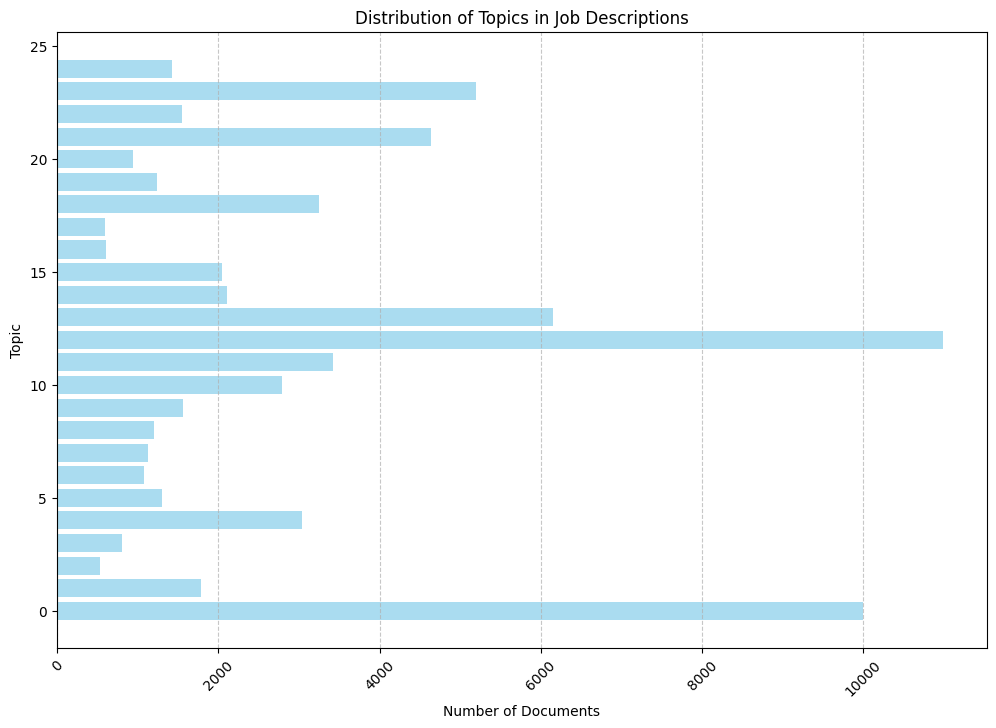

In [47]:
# We can explore the distribution of topics across the documents. 
# Step 1: Count the occurrences of each topic
topic_counts = jobDescriptionDf['Topic'].value_counts().sort_index()

# Step 2: Create the horizontal bar chart
plt.figure(figsize=(12, 8))
plt.barh(topic_counts.index, topic_counts.values, color='skyblue', alpha=0.7)
plt.xlabel('Number of Documents')
plt.ylabel('Topic')
plt.title('Distribution of Topics in Job Descriptions')
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the chart
plt.show()

In [51]:
# We can grab an example of each topic, using the most recent documents. 
# We will then build a prompt for Chat GPT and ask it to apply some possible labels to these topics. 


# Reverse the DataFrame to start from the last row
reversed_df = jobDescriptionDf.iloc[::-1]

# Extract one example row for each unique topic
example_rows = reversed_df.groupby('Topic').first().reset_index()

# Write the example rows to a file with utf-8 encoding
with open('topics.txt', 'w', encoding='utf-8') as file:
    for index, row in example_rows.iterrows():
        file.write(f"Topic: {row['Topic']}\n")
        file.write(f"Description: {row['full_posting_description']}\n")
        file.write("\n ######### \n")


In [53]:
# Maybe we want three example records for each topic

# Reverse the DataFrame to start from the last row
reversed_df = jobDescriptionDf.iloc[::-1]

# Extract three example rows for each unique topic
example_rows = reversed_df.groupby('Topic').head(3).reset_index(drop=True)

# Write the example rows to a file with utf-8 encoding
with open('topicsThreeJobDescriptions.txt', 'w', encoding='utf-8') as file:
    current_topic = None
    for index, row in example_rows.iterrows():
        if row['Topic'] != current_topic:
            if current_topic is not None:
                file.write("\n")
            current_topic = row['Topic']
            file.write(f"Topic: {current_topic}\n")
        file.write(f"Job Description {index % 3 + 1}: {row['full_posting_description']}\n #### \n")



In [57]:
import pandas as pd

# Assuming jobDescriptionDf is already created
# jobDescriptionDf = pd.read_csv('your_file.csv')  # Example to load DataFrame from a CSV

# Reverse the DataFrame to start from the last row
reversed_df = jobDescriptionDf.iloc[::-1]

# Extract the last three rows for each unique topic
example_rows = reversed_df.groupby('Topic').head(3)

# Write the example rows to a file with utf-8 encoding
with open('topicsThreeJobDescriptions.txt', 'w', encoding='utf-8') as file:
    for topic, group in example_rows.groupby('Topic'):
        file.write(f"Time for a new topic. \n Topic: {topic}\n")
        for index, row in group.iterrows():
            file.write(f"Job Description {index + 1}: \n {row['full_posting_description']}\n #### \n")
        file.write("\n")
